# Example optimisation

Take timing.

In [1]:
from time import time

tic = time()

## Imports and prep

In [2]:
from ship_routing.core import Route, WayPoint
from ship_routing.mc import move_random_node
from ship_routing.currents import load_currents

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm

In [4]:
np.random.seed(12345)

## Load currents and plot speed

In [5]:
currents = load_currents(
    data_file="data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_100W-020E_10N-65N.nc"
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.Dataset> Size: 10MB
Dimensions:  (lat: 661, lon: 1321, time: 1)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 8B 2021-01-01
Data variables:
    uo       (time, lat, lon) float32 3MB -0.1356 -0.1479 ... 0.07963 0.05846
    vo       (time, lat, lon) float32 3MB -0.01258 -0.02277 ... 0.2739 0.4073
    speed    (time, lat, lon) float32 3MB 0.1362 0.1497 0.163 ... 0.2852 0.4115
Attributes:
    Conventions:  CF-1.8
    area:         Global
    contact:      https://marine.copernicus.eu/contact
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    institution:  Mercator Ocean International
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    references:   http://marine.copernicus.eu
    source:       MOI GLO12
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...

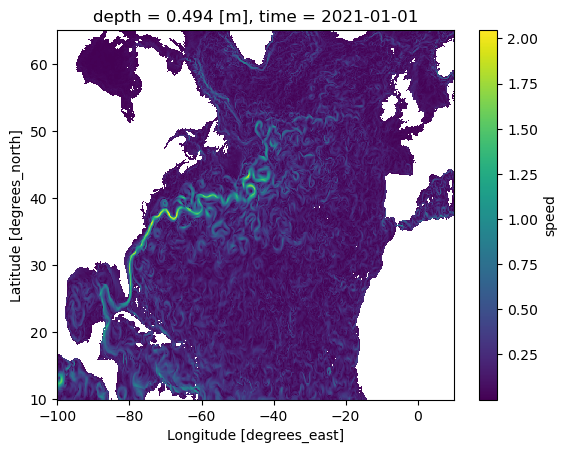

In [6]:
currents.speed.plot()

## Define a route and have a look

In [7]:
route_0 = Route(
    way_points=(
        WayPoint(lon=-80.5, lat=30, time=np.datetime64("2021-01-01")),
        WayPoint(lon=-40, lat=45, time=np.datetime64("2021-01-21")),
    )
).refine(distance_meters=1_000_000)
route_0

Route(way_points=(WayPoint(lon=-80.5, lat=30, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-71.94751834486507, lat=34.97545585815938, time=numpy.datetime64('2021-01-05T23:59:59.999')), WayPoint(lon=-62.37585689326821, lat=39.27188810472032, time=numpy.datetime64('2021-01-10T23:59:59.999')), WayPoint(lon=-51.698963617395066, lat=42.68494881568617, time=numpy.datetime64('2021-01-15T23:59:59.999')), WayPoint(lon=-40.0, lat=45, time=numpy.datetime64('2021-01-21'))))

In [8]:
route_0.data_frame

,lon,lat,time
0,-80.500000,30.000000,2021-01-01 00:00:00.000
1,-71.947518,34.975456,2021-01-05 23:59:59.999
2,-62.375857,39.271888,2021-01-10 23:59:59.999
3,-51.698964,42.684949,2021-01-15 23:59:59.999
4,-40.000000,45.000000,2021-01-21 00:00:00.000


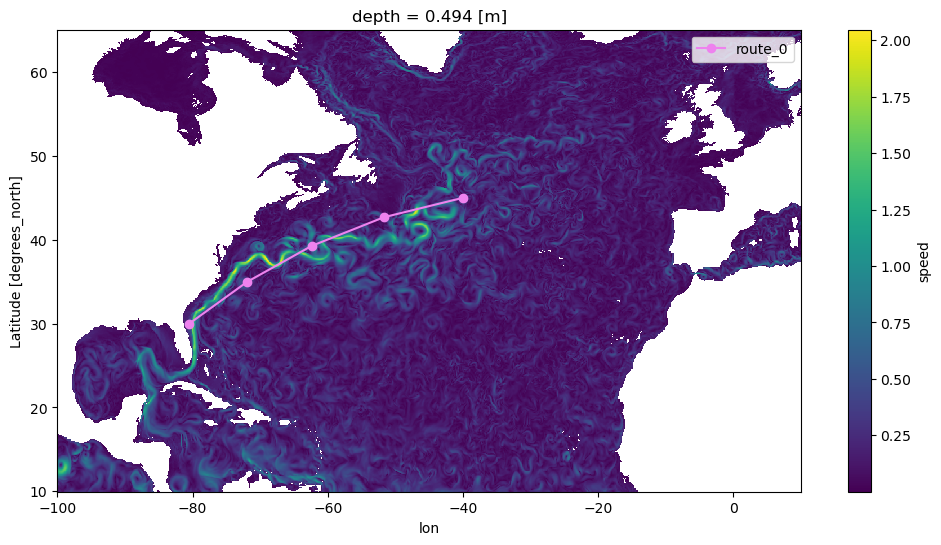

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
currents.speed.mean("time").plot(ax=ax)
route_0.data_frame.plot.line(
    x="lon", y="lat", marker="o", ax=ax, color="violet", label="route_0"
);

## Keep track of cost

In [10]:
cost_steps = []

## First run of optimisation

- max step of 500000 m
- arbitrary direction
- only inner way points
- accept mod if cost is reduced

In [11]:
max_step = 500_00
route_1 = deepcopy(route_0)
cost = route_1.cost_through(currents)
cost_steps.append(cost)

In [12]:
accepted = 0
for n in tqdm.tqdm(range(100)):
    _route_1 = route_1.move_waypoint(
        azimuth_degrees=np.random.uniform(-180, 180),
        n=np.random.randint(1, len(route_1) - 1),
        distance_meters=np.random.uniform(0, max_step),
    )
    _cost = _route_1.cost_through(current_data_set=currents)
    if not np.isnan(_cost) and _cost < cost:
        route_1 = _route_1
        cost = _cost
        accepted += 1
        cost_steps.append(cost)
print(accepted)

100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.70it/s]

19


## Second run of optimisation

- refine route to 500_000 m
- max step of 250000 m
- arbitrary direction
- only inner way points
- accept mod if cost is reduced

In [13]:
max_step = 250_00
route_2 = deepcopy(route_1).refine(500_000)
cost = route_2.cost_through(currents)
cost_steps.append(cost)

In [14]:
# cost reduction steps
accepted = 0
for n in tqdm.tqdm(range(200)):
    _route_2 = route_2.move_waypoint(
        azimuth_degrees=np.random.uniform(-180, 180),
        n=np.random.randint(1, len(route_2) - 1),
        distance_meters=np.random.uniform(0, max_step),
    )
    _cost = _route_2.cost_through(current_data_set=currents)
    if not np.isnan(_cost) and _cost < cost:
        route_2 = _route_2
        cost = _cost
        accepted += 1
        cost_steps.append(cost)
print(accepted)

100%|██████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.13it/s]

55


## Third run of optimisation

- refine route to 250_000 m
- max step of 100000 m
- arbitrary direction
- only inner way points
- accept mod if cost is reduced

In [15]:
max_step = 100_000
route_3 = deepcopy(route_2).refine(250_000)
cost = route_3.cost_through(currents)
cost_steps.append(cost)

In [16]:
# cost reduction steps
accepted = 0
for n in tqdm.tqdm(range(400)):
    _route_3 = route_3.move_waypoint(
        azimuth_degrees=np.random.uniform(-180, 180),
        n=np.random.randint(1, len(route_3) - 1),
        distance_meters=np.random.uniform(0, max_step),
    )
    _cost = _route_3.cost_through(current_data_set=currents)
    if not np.isnan(_cost) and _cost < cost:
        route_3 = _route_3
        cost = _cost
        accepted += 1
        cost_steps.append(cost)
print(accepted)

100%|██████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 26.55it/s]

64


## Fourth run of optimisation

- refine route to 100_000 m
- max step of 50000 m
- arbitrary direction
- only inner way points
- accept mod if cost is reduced

In [17]:
max_step = 50_000
route_4 = deepcopy(route_3).refine(100_000)
cost = route_4.cost_through(currents)
cost_steps.append(cost)

In [18]:
# cost reduction steps
accepted = 0
for n in tqdm.tqdm(range(800)):
    _route_4 = route_4.move_waypoint(
        azimuth_degrees=np.random.uniform(-180, 180),
        n=np.random.randint(1, len(route_4) - 1),
        distance_meters=np.random.uniform(0, max_step),
    )
    _cost = _route_4.cost_through(current_data_set=currents)
    if not np.isnan(_cost) and _cost < cost:
        route_4 = _route_4
        cost = _cost
        accepted += 1
        cost_steps.append(cost)
print(accepted)

100%|██████████████████████████████████████████████████████████████████| 800/800 [01:21<00:00,  9.85it/s]

62


## Show results

<Axes: title={'center': 'depth = 0.494 [m]'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

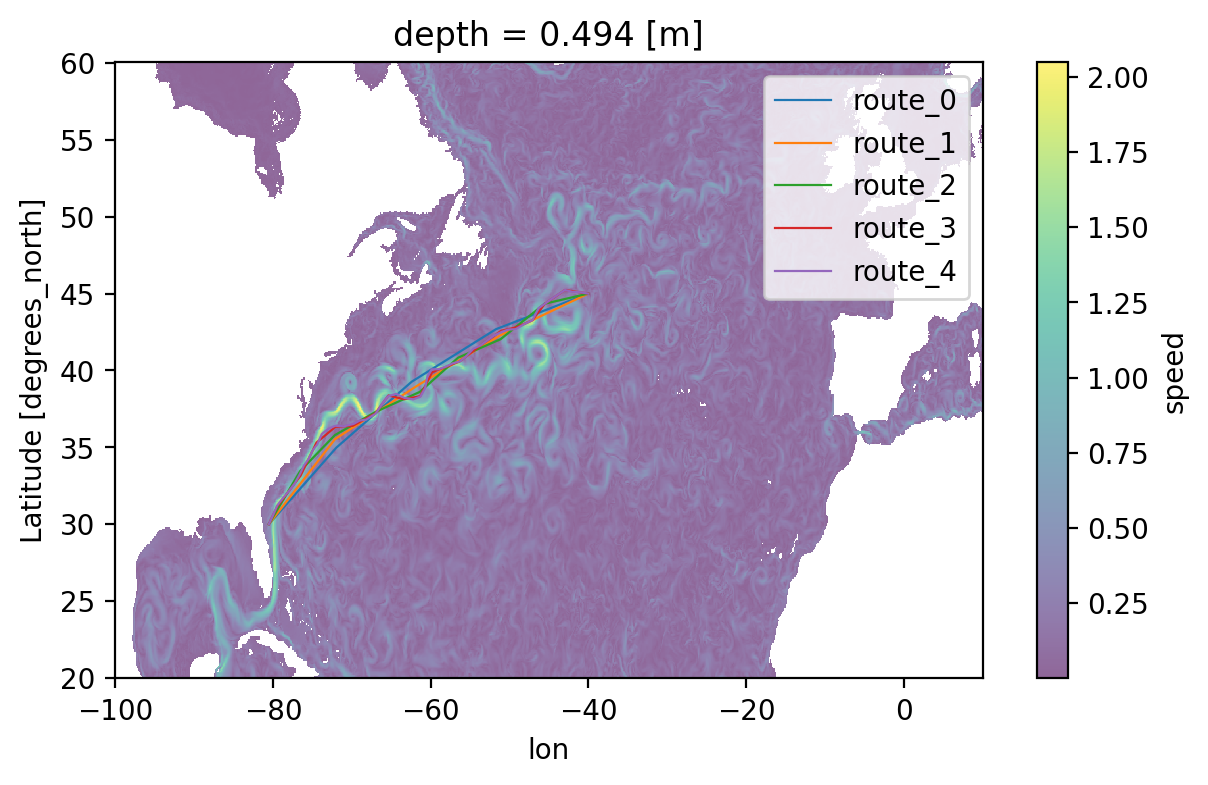

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
currents.speed.mean("time").sel(lon=slice(-100, 10), lat=slice(20, 60)).plot(
    ax=ax, alpha=0.6
)
fig.set_dpi(200)
route_0.data_frame.plot.line(x="lon", y="lat", ax=ax, label="route_0", linewidth=0.8)
route_1.data_frame.plot.line(x="lon", y="lat", ax=ax, label="route_1", linewidth=0.8)
route_2.data_frame.plot.line(x="lon", y="lat", ax=ax, label="route_2", linewidth=0.8)
route_3.data_frame.plot.line(x="lon", y="lat", ax=ax, label="route_3", linewidth=0.8)
route_4.data_frame.plot.line(x="lon", y="lat", ax=ax, label="route_4", linewidth=0.8)

In [20]:
print(route_0.cost_through(currents))
print(route_1.cost_through(currents))
print(route_2.cost_through(currents))
print(route_3.cost_through(currents))
print(route_4.cost_through(currents))

18349790.95921926
16185360.86004507
13881903.279174881
10800069.765285186
9743007.409465887


In [21]:
print(route_0.length_meters)
print(route_1.length_meters)
print(route_2.length_meters)
print(route_3.length_meters)
print(route_4.length_meters)

3897388.430261663
3907196.976450391
3941061.268807992
4068747.8312621736
4116231.548311525


<Axes: xlabel='accepted', ylabel='cost'>

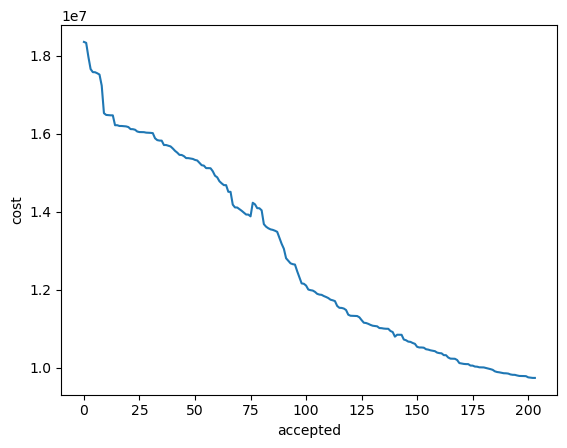

In [24]:
pd.Series(cost_steps, name="cost").plot(ylabel="cost", xlabel="accepted")

## Timing

In [23]:
print("took", time() - tic, "seconds")

took 109.27470207214355 seconds
